# Charge Time Analytics
## Kevin Quigley - x20217366


## Table Of Contents

* [0.Read-me](#readMe)
* [1.Introduction](#into)

* [2.Data Analysis](#anal)     
   * [2.1 Weather Dataset](#aveWeather)
   * [2.2 Wind Energy Dataset](#windEnergy)
   * [2.3 Energy Price Dataset](#Eprice)

* [3. Data Transformation](#transform)
   * [3.1 Transforming Time ](#timeTrans)
   * [3.1 Transforming Wind Vector](#spaceTrans)

* [4. Measuring Colinearity](#colinear)
   
* [5. Energy Price Dataset](#ePrice)
   * [5.1 Energy Price Dataset Analaysis](#ePriceAnal)
   * [5.2 Energy Price Dataset Corelations](#ePriceCor)
   
* [6. Saving The Cleaned Dataset](#save)

* [7. Investigating Effect of Russia's invasion of Ukraine](#ukraine)

# 0. Readme <a name="readMe"></a>

The main charge time analytics folder is divded into two sub folders. The first "download" contains the download files needed to scrape data from the three respective data sources. Currently this pulls only historical data and will be updated to pull real time weather data for low electricity price predictions.

metDownload.sh is a bash file which pulls historical data from 8 weather stations across Ireland which provide hourly data on wind direction, precipitation, and wind strength on an hourly basis for the last 5 years. each dataset is pulled, and unzipped into the download folder.


The fileDownloader_*_1.sh scrapes 1 years worth of historical data from the seai dashboard website. Each source for a given month has to be executed seperately, as downloading all at once can crash the remote server. There is other data available for download from the website, but attempting remote download using fileDownloader_*_1.sh causes the SEAI website to crash too. 

The file priceFinder.sh downloads historical price data for a list of times from SEMO using a list of times generated by timeGenerator.py. The range of times can be controlled using the variables set within the timegenerator function. Currently, only the last two months of price data is available from the semo website. So while it cannot currently be used for building models, it can be used to compare results, and confirm that high winds are associated with higher price data from the central operator.

Raw files are then moved individually to the data/ folder to ensure that they are not over-written from an accidental download, which if the SEAI website is down, can result in empty files. After moving the data files, they are joined together using the joiner.py file. This creates a single "weatherMerged" csv file. 

In order to pull this main file from the remote server, the file pullData.sh is used on a local machine. 


## 1. Introduction<a name="into"></a>

### The WeatherMerged dataset

The data is pulled from the server by executing "bash data/pullData.sh".
After data is pulled it is then read in as follows:-

In [11]:
import pandas as pd
import datetime as td
import  numpy as np
weatherMerged = pd.read_csv('data/weatherMerged.csv')
print("The Merged dataset's columns are denoted by:- \n \n ",weatherMerged.columns)
weatherMerged= weatherMerged.sort_values(by="date2")
# Just a reminder that the columns available from the met Eireann API are
#'dub_wddir','dub_wdsp','dub_temp','dub_msl'
#'don_wddir','don_wdsp','don_temp','don_msl'
#'cla_wddir','cla_wdsp','cla_temp','cla_msl'
#'cor_wddir','cor_wdsp','cor_temp','cor_msl'
df = weatherMerged
len(weatherMerged)

The Merged dataset's columns are denoted by:- 
 
  Index(['Date&Time', 'ActualGenerationMW', 'ForecastWind', 'ActualWind',
       'ActualDemand', 'ForecastDemand', 'date2', 'minute', 'ker_ind',
       'ker_rain',
       ...
       'tip_ind.2', 'tip_wetb', 'tip_dewpt', 'tip_vappr', 'tip_rhum',
       'tip_msl', 'tip_ind.3', 'tip_wdsp', 'tip_ind.4', 'tip_wddir'],
      dtype='object', length=144)


C:\Users\kevin\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (2,3,4,39,41,111,123,131,133,135,136,137,138,139,141,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


27748

The above dataset has over 26000 rows and  144 columns.
The central grid columns from SEAI are as follows
- The actual generation represents the total generated capacity in Ireland for a given hour in MW
- The Actual Demand is the total demand on the Irish grid in MW
- ForecastWind is the total forecasted wind power one week ahead for the Irish grid
- ActualWind is the on the spot wind energy being generated for the Irish grid

From Met Eireann for the eight different weather stations we have the columns which are relevant to generation are
- Rain is the total precipitation amount
- Temp is the air temperature
- wetb is the wet bulb temperature
- wdsp is the  mean hourly wind spead in kt
- wddir is the wind direction (from 0-360)
- clamt is the cloud amount (in okta)
Again, the overall goal is to in real time calculate the cheapest time to charge an electric vehicle. This time will be both optimized for the grid operator and the consumer.

### The ePrice dataset
The Irish Single Electric Market Operator group(SEMO) controls the price of electricity. A diagram showing their contribution is shown below:-
![title](img/SEMOsystem.jpg)

The Imbalance Settlement Price is the price in EUR per Megawatt Hour (MWh), meaning the cost of energy actions taken by the TSO to balance demand and supply in a 30 minute trading period. (PIMB)

The Net Imbalance Volume is the amount of energy needed to balance the system, this can be positive or negative indicating if the system is long or short for generation required in a 30 minute trading period. (NIV (MWh))

In [12]:
ePrice = pd.read_csv('data/ePrice.csv')
ePrice.columns= ['StartTime', 'EndTime', 'NetImbalanceVolume','ImbalanceSettlementPrice']
print(ePrice)


                StartTime                 EndTime  NetImbalanceVolume  \
0     2022-05-27T00:00:00   \t2022-05-27T00:30:00             -29.291   
1     2022-05-27T00:30:00   \t2022-05-27T01:00:00             -23.329   
2     2022-05-27T01:00:00   \t2022-05-27T01:30:00             -36.292   
3     2022-05-27T01:30:00   \t2022-05-27T02:00:00             -42.894   
4     2022-05-27T02:00:00   \t2022-05-27T02:30:00             -33.407   
...                   ...                     ...                 ...   
1103  2022-07-01T21:30:00   \t2022-07-01T22:00:00              15.843   
1104  2022-07-01T22:00:00   \t2022-07-01T22:30:00              32.151   
1105  2022-07-01T22:30:00   \t2022-07-01T23:00:00              24.988   
1106  2022-07-01T23:00:00   \t2022-07-01T23:30:00              30.974   
1107  2022-07-01T23:30:00   \t2022-07-02T00:00:00              21.779   

      ImbalanceSettlementPrice  
0                        74.45  
1                        82.32  
2                       

A screenshot from the seai smart dashboard website

![title](img/imbvImage.png)

## 2. Data Analysis <a name="anal"></a>


### 2.1 Average Weather conditions <a name="aveWeather"></a>


1. Looking at average weather conditions in the various stations we have the following

In [118]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as td
import datetime

In [14]:
weatherMerged = pd.read_csv('data/weatherMerged.csv')
df = weatherMerged



df['date2'] =  pd.to_datetime(df['date2']) #, unit='s')

df=df._convert(numeric=True)
for i in range(len(df)):
    if (df.date2[i]< datetime.date(2000, 6, 29)):
        print(i)


C:\Users\kevin\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (2,3,4,39,41,111,123,131,133,135,136,137,138,139,141,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\kevin\AppData\Local\Temp/ipykernel_16664/3918622137.py:10: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if (df.date2[i]< datetime.date(2000, 6, 29)):


C:\Users\kevin\AppData\Local\Temp/ipykernel_16664/2346685266.py:10: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if (df.date2[i]< datetime.date(2000, 6, 29)):


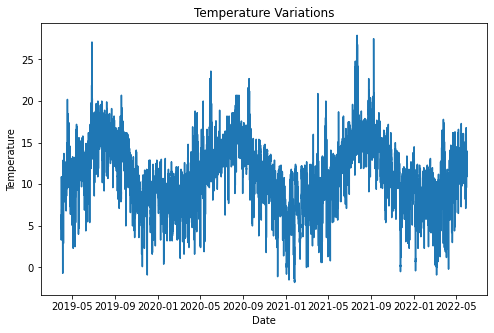

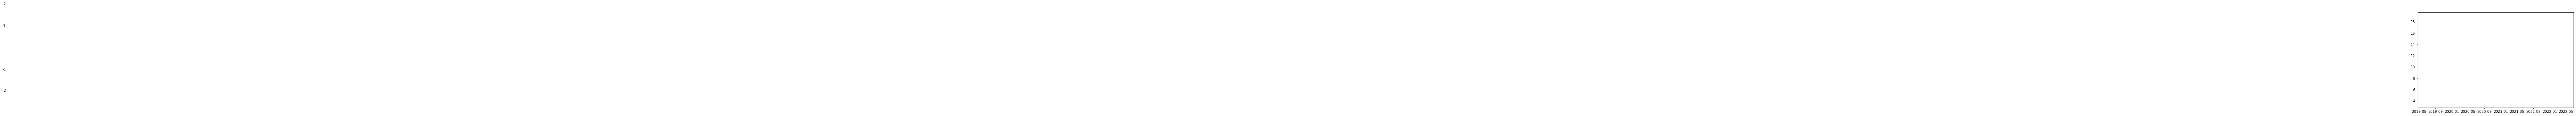

In [15]:
#Generating a plot of the variaiton of temperature for the last 3 years
import matplotlib.pyplot as plt
import datetime 
df=df._convert(numeric=True)
df['date2'] =  pd.to_datetime(df['date2'], unit='s')




for i in range(len(df)):
    if (df.date2[i]< datetime.date(2000, 6, 29)):
        print(i)





plt.figure(figsize=(8,5))
plt.title("Temperature Variations") # Title
#plt.ylim(-40,40) # Setting y limits
plt.plot(df.date2,df['ker_temp']); # Plotting scatter
plt.xlabel("Date")
plt.ylabel("Temperature")

plt.figure(figsize=(8,5))
plt.hlines(y=df['ker_temp'].mean(), xmin=0, xmax=max(df["ker_temp"])) # Mean
plt.xlim([datetime.date(2019, 4, 21), datetime.date(2022, 6, 29)])

for std_int in [-2, -1, 1, 2]: # Going through different stds from the mean
    standard_deviation = df['ker_temp'].mean() + df['ker_temp'].std()*std_int
    
    plt.hlines(y=standard_deviation,
               xmin=0,
               xmax=max(df["ker_temp"]),
               linestyles='dashed',
               colors='green'); # 1 std above
    
    # Giving labels to the lines we just drew
    plt.text(y=standard_deviation + 2, x=-10, s=std_int, ha='center')
# Can't plot using date, as some of the indices are off
#plt.figure(figsize=(266,55))

In [119]:
# Backfilling missing values and ensuring types are correct
import numpy as np 
df = weatherMerged
df.loc[df['tip_temp']==' ']= np.nan 



data_1 = df['dub_temp']
data_2 = df['cor_temp']
data_3 = df['ker_temp']
data_4 = df['tip_temp']
data_5 = df['may_temp']
data_6 = df['sli_temp']
data_7 = df['don_temp']
data = [data_1, data_2, data_3, data_4,data_5,data_6,data_7]

try:
    data_4.astype('float')
    print("All Good")
except ValueError:
        print("Something wrong with the types!")
#return("Something wrong with the types")
for i in range(len(data_4)):
    try:
        s = np.array(data_4[i],dtype = np.float)
    except ValueError:
        print("The value is",data_4[i],". The number is",i )
        print()

df = df.drop(['tip_temp'], axis = 1)
data_4 = weatherMerged['tip_temp']
data_4_i = []
def conv(s):
    try:
        s=float(s)
    except ValueError:
        pass    
    return s
for i in data_4:
    j=conv(i)
    data_4_i.append(j)
#xtra = {'tip_temp': data_4_i}
#df = df.append(pd.DataFrame(xtra))

df['tip_temp']= np.array(data_4_i, dtype=np.float) 

data_4 = df['tip_temp']
df=df.replace('', np.nan, regex=True)
df = df.dropna()


All Good


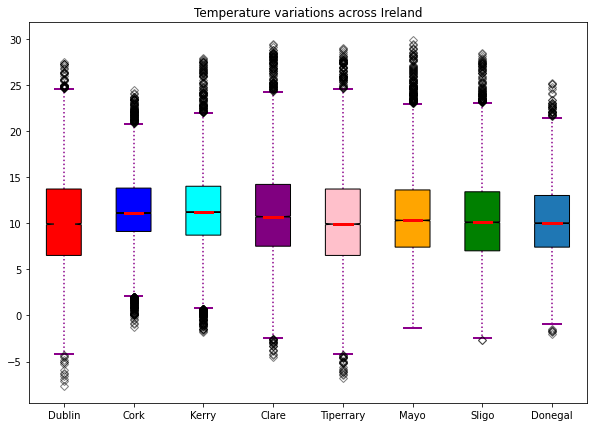

Looking above we can see broadly similar variations in terms of temperature across all counties. More coastal stations tend to have a smaller range, such as Newport in Mayo, or in Sherkin Island


In [120]:
# Generating a plot of temperature outliers 
import numpy as np
 
# Creating dataset
np.random.seed(10)
data_1 = df['dub_temp']
data_2 = df['cor_temp']
data_3 = df['ker_temp']
data_4 = df['cla_temp']
data_5 = df['tip_temp']
data_6 = df['may_temp']
data_7 = df['sli_temp']
data_8 = df['don_temp']
data = [data_1, data_2, data_3, data_4,data_5,data_6,data_7,data_8]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 1)
 
colors = ['red','blue','cyan','purple','pink','orange','green']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_xticklabels(['Dublin', 'Cork',
                    'Kerry', 'Clare',
                    'Tiperrary', 'Mayo',
                    'Sligo','Donegal'])

 
# Adding title
plt.title("Temperature variations across Ireland")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()
print("Looking above we can see broadly similar variations in terms of temperature across all counties. More coastal stations tend to have a smaller range, such as Newport in Mayo, or in Sherkin Island")

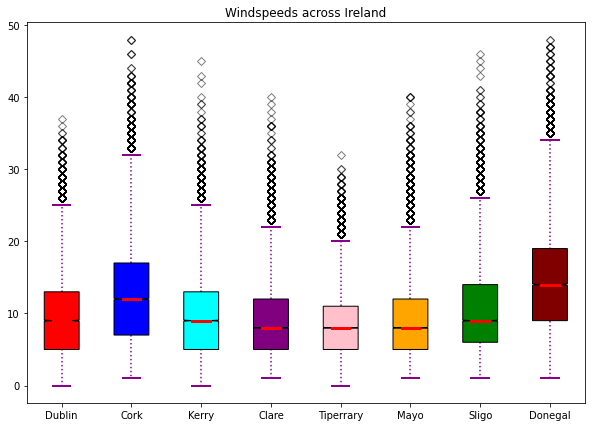

Above we see that more coastal stations have a much larger variation in wind speed, due to their exposed locations along the coast. Here Cork and Donegal have the largest spread in wind speeds, with inland tiperrary and Dublin having the smallest


In [18]:
# Generatign a plot of winspeed outliers at all weather stations
import matplotlib.pyplot as plt
import numpy as np

df = weatherMerged
df=df._convert(numeric=True)

# Creating dataset
np.random.seed(10)
data_1 = df['dub_wdsp']
data_2 = df['cor_wdsp']
data_3 = df['ker_wdsp']
data_4 = df['cla_wdsp']
data_5 = df['tip_wdsp']
data_6 = df['may_wdsp']
data_7 = df['sli_wdsp']
data_8 = df['don_wdsp']

data1 = data_1.to_numpy()
data2 = data_2.to_numpy()
data3 = data_3.to_numpy()
data4 = data_4.to_numpy()
data5 = data_5.to_numpy()
data6 = data_6.to_numpy()
data7 = data_7.to_numpy()
data8 = data_8.to_numpy()


data1 = data1[~np.isnan(data1)] 
data2 = data2[~np.isnan(data2)] 
data3 = data3[~np.isnan(data3)] 
data4 = data4[~np.isnan(data4)] 
data5 = data5[~np.isnan(data5)] 
data6 = data6[~np.isnan(data6)] 
data7 = data7[~np.isnan(data7)] 
data8 = data8[~np.isnan(data8)] 

data = [data1, data2, data3, data4,data5,data6,data7,data8]


#data = [data_1, data_2, data_3, data_4,data_5,data_6,data_7,data_8]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 1)
 
colors = ['red','blue','cyan','purple','pink','orange','green','maroon']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_xticklabels(['Dublin', 'Cork',
                    'Kerry', 'Clare',
                    'Tiperrary', 'Mayo',
                    'Sligo','Donegal'])

 
# Adding title
plt.title("Windspeeds across Ireland")
 
# Removing top axes and right axes

# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.savefig('analysisImages/irelandWindspeeds.png')
# show plot
plt.show()
print("Above we see that more coastal stations have a much larger variation in wind speed, due to their exposed locations along the coast. Here Cork and Donegal have the largest spread in wind speeds, with inland tiperrary and Dublin having the smallest")

In [121]:
# Generating a plot of wind direction variabilities across all stations
import matplotlib.pyplot as plt
import numpy as np
 
# Creating dataset
np.random.seed(10)
data_1 = df['dub_wddir']
data_2 = df['cor_wddir']
data_3 = df['ker_wddir']
data_4 = df['cla_wddir']
data_5 = df['tip_wddir']
data_6 = df['may_wddir']
data_7 = df['sli_wddir']
data_8 = df['don_wddir']

data1 = data_1.to_numpy()
data2 = data_2.to_numpy()
data3 = data_3.to_numpy()
data4 = data_4.to_numpy()
data5 = data_5.to_numpy()
data6 = data_6.to_numpy()
data7 = data_7.to_numpy()
data8 = data_8.to_numpy()


data1 = data1[~np.isnan(data1)] 
data2 = data2[~np.isnan(data2)] 
data3 = data3[~np.isnan(data3)] 
data4 = data4[~np.isnan(data4)] 
data5 = data5[~np.isnan(data5)] 
data6 = data6[~np.isnan(data6)] 
data7 = data7[~np.isnan(data7)] 
data8 = data8[~np.isnan(data8)] 

data = [data1, data2, data3, data4,data5,data6,data7,data8]

#data = [data_1, data_2, data_3, data_4,data_5,data_6,data_7,data_8]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 1)
 
colors = ['red','blue','cyan','purple','pink','orange','green']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_xticklabels(['Dublin', 'Cork',
                    'Kerry', 'Clare',
                    'Tiperrary', 'Mayo',
                    'Sligo','Donegal'])

 
# Adding title
plt.title("Most prominent wind directions across Ireland")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()
print("All stations have similar prominant wind directions across the country, due Irelands exposure to the gulf stream")

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### Wind Energy Dataset <a name="windEnergy"></a>

#### Total Wind Energy Produced


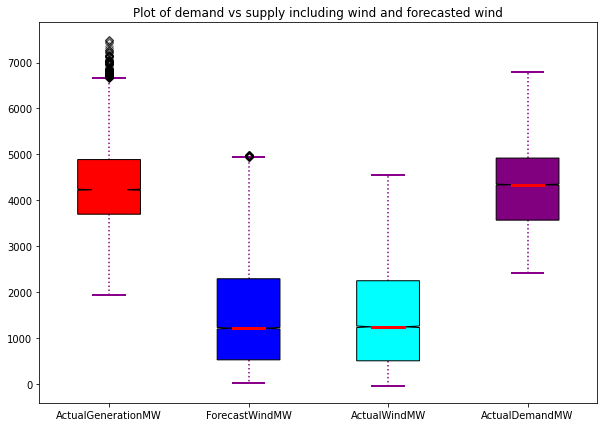

In [20]:
# Plotting variation of generation inputs
import datetime as td
import matplotlib.pyplot as plt
import numpy as np
 
# Creating dataset
np.random.seed(10)
data_1 = df['ActualGenerationMW']
data_2 = df['ForecastWind']
data_3 = df['ActualWind']
data_4 = df['ActualDemand']

data1 = data_1.to_numpy()
data2 = data_2.to_numpy()
data3 = data_3.to_numpy()
data4 = data_4.to_numpy()

data1 = data1[~np.isnan(data1)] 
data2 = data2[~np.isnan(data2)] 
data3 = data3[~np.isnan(data3)] 
data4 = data4[~np.isnan(data4)] 
data = [data1, data2, data3, data4]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True')
 
colors = ['red','blue','cyan','purple','pink']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_xticklabels(['ActualGenerationMW', 'ForecastWindMW',
                    'ActualWindMW','ActualDemandMW'])

# Adding title
plt.title("Plot of demand vs supply including wind and forecasted wind")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.savefig('analysisImages/irelandPowers.png')
# show plot
plt.show()

## Using Fourier Transforms to extract important time periodicities

C:\Users\kevin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


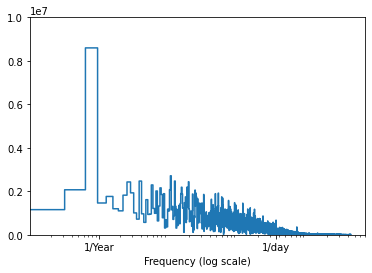

In [21]:
## Generating a plot of fourier transform of forecast wind to show periodicities

df1 = df[['date2',"ActualGenerationMW","ForecastWind","ActualWind","ActualDemand",'dub_wddir','dub_wdsp','dub_temp','dub_msl','don_wddir','don_wdsp','don_temp','don_msl','cla_wddir','cla_wdsp','cla_temp','cla_msl','cor_wddir','cor_wdsp','cor_temp','cor_msl']]


weatherMerged= weatherMerged.sort_values(by="date2")
# Just a reminder that the columns available are 'dub_wddir','dub_wdsp','dub_temp','dub_msl'
#'don_wddir','don_wdsp','don_temp','don_msl'
#'cla_wddir','cla_wdsp','cla_temp','cla_msl'
#'cor_wddir','cor_wdsp','cor_temp','cor_msl'

df1['hour']=df1['date2'].dt.hour
df1['dayOfWeek']=df1['date2'].dt.day_of_week
df1['dayOfYear']=df1['date2'].dt.day_of_year
df1=df1.dropna()


sum_col = df1['dayOfYear'][0]+(df1['hour']/24)
df1=df1._convert(numeric=True)

import tensorflow as tf
fft = tf.signal.rfft(df1['ForecastWind'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1['dub_temp'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 10000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

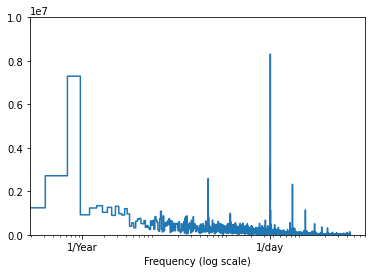

In [22]:
## Generating a plot of total actual generation of forecast wind to show periodicities
import tensorflow as tf
fft = tf.signal.rfft(df1['ActualGenerationMW'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1['ActualGenerationMW'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 10000000)
#plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

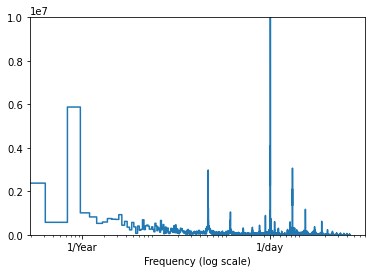

In [23]:
## Generating a plot of fourier transform of Actual Wind generated to show periodicities
fft = tf.signal.rfft(df1['ActualDemand'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1['ActualDemand'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 10000000)
#plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
## Generating a plot of fourier transforms of target variables to show periodicities
fig, axs = plt.subplots(2, 2)

plt.setp(axs, xticks=[1,7, 365.2524], xticklabels=['1/Year','1/week','1/day'])

fft = tf.signal.rfft(df1['ActualDemand'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1['ActualDemand'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
axs[0, 0].set_title("Actual Electricity Demand")
axs[0, 0].step(f_per_year, np.abs(fft))
axs[0, 0].set_xscale('log')
axs[0, 0].set_ylim(0, 10000000)
#plt.xlim([0.1, max(plt.xlim())])
#axs[0, 0].set_xticks([1, 365.2524], set_labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


fft = tf.signal.rfft(df1['ActualGenerationMW'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1['ActualGenerationMW'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
axs[0, 1].set_title("Actual Electricity Generated")
axs[0, 1].step(f_per_year, np.abs(fft))
axs[0, 1].set_xscale('log')
axs[0, 1].set_ylim(0, 10000000)
#plt.xlim([0.1, max(plt.xlim())])
#axs[0, 0].set_xticks([1, 365.2524], set_labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


fft = tf.signal.rfft(df1['ForecastWind'])
f_per_dataset = np.arange(0, len(fft))
n_samples_h = len(df1['ForecastWind'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
axs[1, 0].step(f_per_year, np.abs(fft))
axs[1, 0].set_xscale('log')
axs[1, 0].set_ylim(0, 10000000)
axs[1, 0].set_title("Forecasted Wind Generated")

#plt.xlim([0.1, max(plt.xlim())])
#axs[0, 0].set_xticks([1, 365.2524], set_labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


fft = tf.signal.rfft(df1['dub_wdsp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1['dub_wdsp'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
axs[1, 1].step(f_per_year, np.abs(fft))
axs[1, 1].set_xscale('log')
axs[1, 1].set_ylim(0, 50000)
axs[1, 0].set_title("Dublin Wind Speed")
#plt.xlim([0.1, max(plt.xlim())])
#axs[0, 0].set_xticks([1, 365.2524], set_labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


plt.setp(axs, xticks=[1, 365.2524], xticklabels=['1/Year', '1/day'])


#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
plt.savefig('analysisImages/FourierTransform.png')

In [ ]:
#Below plots a fourier transform of the demand for electricity, which has a significant daily and yearly fluctuation
fig, axs = plt.subplots(1, 1)

plt.setp(axs, xticks=[1, 365.2524], xticklabels=['1/Year', '1/day'])

fft = tf.signal.rfft(df1['ActualDemand'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1['ActualDemand'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
axs.set_title("Actual Electricity Demand")
axs.step(f_per_year, np.abs(fft))
axs.set_xscale('log')
axs.set_ylim(0, 10000000)
#plt.xlim([0.1, max(plt.xlim())])
#axs[0, 0].set_xticks([1, 365.2524], set_labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

plt.setp(axs, xticks=[1, 365.2524], xticklabels=['1/Year', '1/day'])


#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
plt.savefig('analysisImages/ActualDemandTransform.png')

## 3. Transforming Columns <a name="transform"></a> 



### 3.1  Transforming Time Columns <a name="timeTrans"></a> 

In [122]:
import math as ma
# This transforms the time columns to create continuous variables
df1["sin_hour"]=np.sin(df1["hour"]/24*2*ma.pi)
df1["sin_day"]=np.sin(df1["dayOfYear"]/365*(2*ma.pi))


df1["cos_hour"]=np.sin(df1["hour"]/24*2*ma.pi)
df1["cos_day"]=np.sin(df1["dayOfYear"]/365*(2*ma.pi))

![title](img/timeRotation.png)
![title](img/timeCalc.png)

'[title]' is not recognized as an internal or external command,
operable program or batch file.
'[title]' is not recognized as an internal or external command,
operable program or batch file.


### 3.2 Constructing a vector from the periodic time-series data <a name="spaceTrans"></a> 

Above we see that the wind direction is shown in degrees. This is not an ideal format for the direction to be entered as a variable for numerical modelling as 360° and 0° are equal, and so the model should warp around.

Secondly, wind direction is found to have a negatory effect if windspeed is high, (See there opposite assication with generation shown in the diagram above). Therefore creating a wind vector which is a combination of the two would be optimal

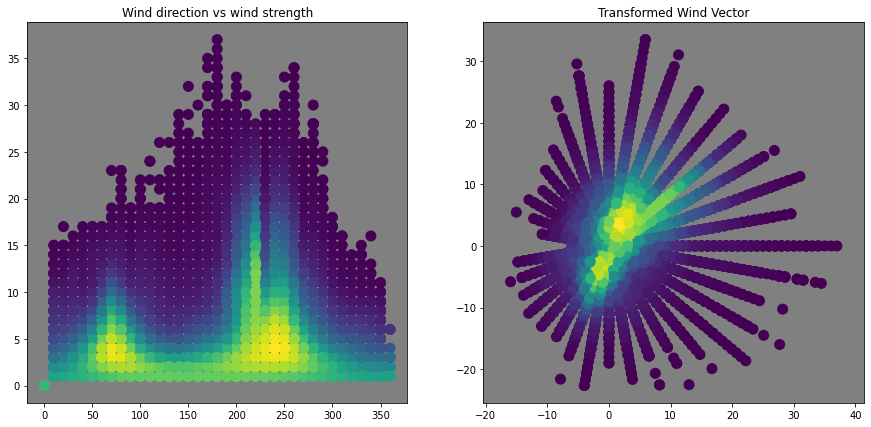

In [38]:
# The following plots a comparison of the un-transformed and transformed wind vector- 
#the second is a more sensible, continuous input for deep learning algorithms

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

df1=df1._convert(numeric=True)
# Generate fake data
df1 = df1[df1['dub_wdsp'].notna()]
df1 = df1[df1['dub_wddir'].notna()]


df1["sin_dub_wddir"]=np.sin((df1["dub_wddir"]-180)/360*2*ma.pi)
df1["cos_dub_wddir"]=np.cos((df1["dub_wddir"]-180)/360*2*ma.pi)


x = df1["dub_wdsp"]*df1["cos_dub_wddir"]
y = df1["dub_wdsp"]*df1["sin_dub_wddir"]




# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)


fig, axs = plt.subplots(1,2,figsize=(15, 15),subplot_kw=dict(box_aspect=1))


axs[1].scatter(x, y, c=z, s=100)
axs[1].set_aspect('equal')
axs[1].set_facecolor('grey')
#axs[0].set_lim(-20,30)
axs[1].set_title('Transformed Wind Vector')


axs[0].scatter(df1["dub_wddir"], df1["dub_wdsp"], c=z, s=100)
#axs01].set_aspect('equal')
axs[0].set_facecolor('grey')
axs[0].set_title('Wind direction vs wind strength')
#axs[1].set_lim(0,30)
#axs.set_aspect('equal')
#plt.ylim(-20,30)
plt.savefig('analysisImages/dub_wddirComp.png')
plt.show()



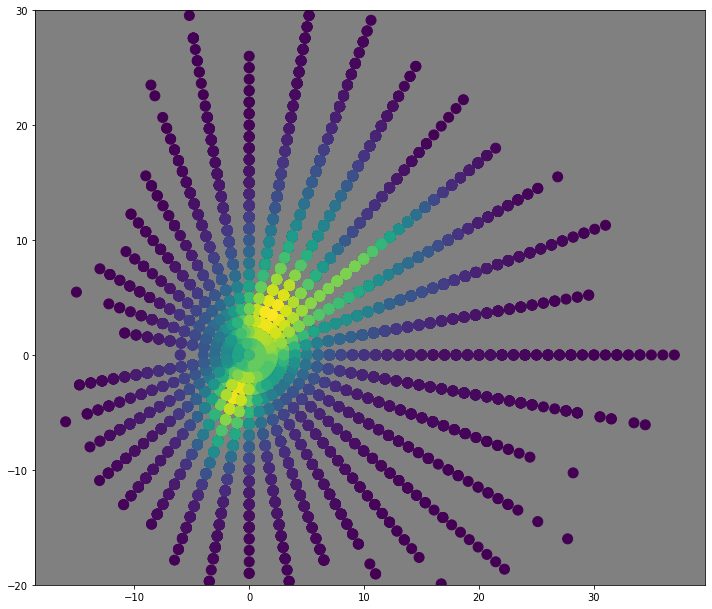

In [39]:
# Interesting to compare the different density plots for wind directions in the various weather stations
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

df1=df1._convert(numeric=True)

df1 = df1[df1['dub_wdsp'].notna()]
df1 = df1[df1['dub_wddir'].notna()]


df1["sin_dub_wddir"]=np.sin((df1["dub_wddir"]-180)/360*2*ma.pi)
df1["cos_dub_wddir"]=np.cos((df1["dub_wddir"]-180)/360*2*ma.pi)


x = df1["dub_wdsp"]*df1["cos_dub_wddir"]
y = df1["dub_wdsp"]*df1["sin_dub_wddir"]




# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
ax. set_aspect('equal')
ax.set_facecolor('grey')
fig.set_size_inches(12, 12)
plt.ylim(-20,30)
plt.savefig('analysisImages/dub_wddir.png')
plt.show()


In [40]:
# New column creation, these are then saved in the new, transformed dataset which is used as an input to the ML algorithms

#Dublin
df1["sin_dub_wddir"]=np.sin((df1["dub_wddir"]-180)/360*2*ma.pi)
df1["cos_dub_wddir"]=np.cos((df1["dub_wddir"]-180)/360*2*ma.pi)
#Cork
df1["sin_cor_wddir"]=np.sin((df1["cor_wddir"]-180)/360*2*ma.pi)
df1["cos_cor_wddir"]=np.cos((df1["cor_wddir"]-180)/360*2*ma.pi)
#Clare
df1["sin_cla_wddir"]=np.sin((df1["cla_wddir"]-180)/360*2*ma.pi)
df1["cos_cla_wddir"]=np.cos((df1["cla_wddir"]-180)/360*2*ma.pi)
#Donegal
df1["sin_don_wddir"]=np.sin((df1["don_wddir"]-180)/360*2*ma.pi)
df1["cos_don_wddir"]=np.cos((df1["don_wddir"]-180)/360*2*ma.pi)





#Dublin
df1['cos_dub_vec'] = df1["dub_wdsp"]*np.sin((df1["dub_wddir"]-180)/360*2*ma.pi)
df1['sin_dub_vec'] = df1["dub_wdsp"]*np.cos((df1["dub_wddir"]-180)/360*2*ma.pi)

#Cork
df1['cos_cor_vec'] = df1["cor_wdsp"]*np.sin((df1["cor_wddir"]-180)/360*2*ma.pi)
df1['sin_cor_vec'] = df1["cor_wdsp"]*np.cos((df1["cor_wddir"]-180)/360*2*ma.pi)

#Clare
df1['cos_cla_vec'] = df1["cla_wdsp"]*np.sin((df1["cla_wddir"]-180)/360*2*ma.pi)
df1['sin_cla_vec'] = df1["cla_wdsp"]*np.cos((df1["cla_wddir"]-180)/360*2*ma.pi)

#Donegal
df1['cos_don_vec'] = df1["don_wdsp"]*np.sin((df1["don_wddir"]-180)/360*2*ma.pi)
df1['sin_don_vec'] = df1["don_wdsp"]*np.cos((df1["don_wddir"]-180)/360*2*ma.pi)


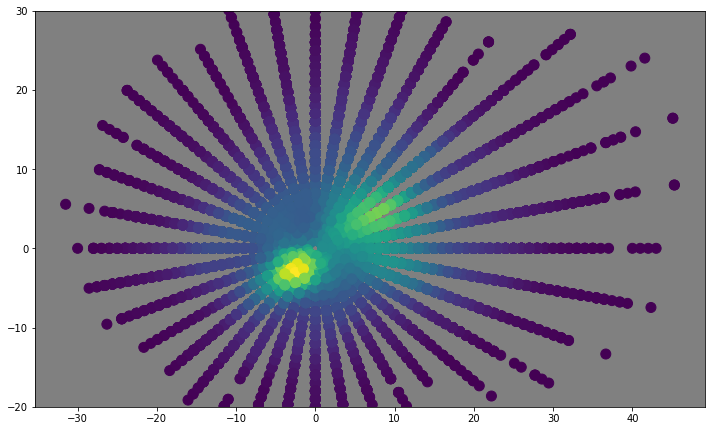

In [123]:
# More different density plots for wind directions in the various weather stations
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

df1=df1._convert(numeric=True)
# Generate fake data

x =df1['cos_cor_vec']
y = df1['sin_cor_vec']




# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
ax. set_aspect('equal')
ax.set_facecolor('grey')
fig.set_size_inches(12, 12)
plt.ylim(-20,30)
plt.show()

## 4. Measuring Colinearity <a name="colinear"></a> 

Many of the columns can be linearly independent, and we now search for eigenvectors in the dataframe.

In [124]:
# Generating a correlation plot of all columns to explore dependencies
corr = df1.corr()
corr.style.background_gradient(cmap='coolwarm')

,ActualGenerationMW,ForecastWind,ActualWind,ActualDemand,dub_wddir,dub_wdsp,dub_temp,dub_msl,don_wddir,don_wdsp,don_temp,don_msl,cla_wddir,cla_wdsp,cla_temp,cla_msl,cor_wddir,cor_wdsp,cor_temp,cor_msl,hour,dayOfWeek,dayOfYear,sin_hour,sin_day,cos_hour,cos_day,sin_dub_wddir,cos_dub_wddir,sin_cor_wddir,cos_cor_wddir,sin_cla_wddir,cos_cla_wddir,sin_don_wddir,cos_don_wddir,cos_dub_vec,sin_dub_vec,cos_cor_vec,sin_cor_vec,cos_cla_vec,sin_cla_vec,cos_don_vec,sin_don_vec,year,month,totalImbalance,totalImbalancep,imbalanceAverage,imbalanceVar,imbalanceVarAvg,ActualDemandAvg
ActualGenerationMW,1.000000,0.522248,0.594590,0.795935,0.047635,0.410142,-0.127322,-0.157065,-0.008676,0.396569,-0.192204,-0.199858,0.065978,0.439769,-0.126664,-0.155350,0.155206,0.438057,-0.157069,-0.131546,0.425001,-0.145626,-0.047080,-0.433463,0.042425,-0.433463,0.042425,0.047327,0.093029,0.123490,0.147348,0.057276,0.149872,0.016072,0.103670,0.139592,0.241764,0.169689,0.173386,0.110700,0.208192,0.055537,0.144136,0.178622,-0.046645,-0.036428,0.354580,0.098844,0.257722,0.462186,0.458979
ForecastWind,0.522248,1.000000,0.953051,0.127400,0.102829,0.793730,-0.134311,-0.402133,0.028065,0.716645,-0.174446,-0.489867,0.111483,0.779794,-0.139164,-0.397468,0.259161,0.780772,-0.140733,-0.348418,0.012361,0.016969,-0.071120,-0.022293,0.077871,-0.022293,0.077871,0.104587,0.260653,0.267425,0.225125,0.123919,0.266763,0.063247,0.201365,0.308185,0.543767,0.384351,0.346070,0.223048,0.429794,0.141293,0.285730,0.098320,-0.072982,0.738738,0.630426,0.256806,0.131849,0.366208,0.340253
ActualWind,0.594590,0.953051,1.000000,0.195119,0.086338,0.757947,-0.126256,-0.368428,0.014333,0.707449,-0.165505,-0.449711,0.098411,0.755866,-0.134173,-0.366292,0.250013,0.746752,-0.134267,-0.322364,0.062847,-0.008028,-0.069913,-0.078116,0.071218,-0.078116,0.071218,0.088352,0.250989,0.252460,0.232805,0.105432,0.265957,0.051337,0.206060,0.286409,0.504675,0.344513,0.332034,0.191599,0.404685,0.126436,0.275005,0.084996,-0.071798,0.732479,0.640417,0.248751,0.151413,0.377736,0.351117
ActualDemand,0.795935,0.127400,0.195119,1.000000,0.043495,0.155800,-0.058255,-0.044160,0.009914,0.136391,-0.136813,-0.055711,0.053166,0.154238,-0.057239,-0.036343,0.091719,0.143279,-0.107826,-0.026010,0.601300,-0.177406,-0.046891,-0.603450,0.037121,-0.603450,0.037121,0.049162,-0.017617,0.060716,0.079578,0.058367,0.067956,0.035118,-0.015963,0.065040,0.046752,0.065602,0.047984,0.080852,0.058964,0.048589,0.019165,0.183275,-0.045443,-0.524784,-0.283826,0.010551,0.224768,0.360604,0.406088
dub_wddir,0.047635,0.102829,0.086338,0.043495,1.000000,0.185236,-0.088292,-0.108802,0.507710,0.188212,-0.024402,-0.189816,0.458608,0.067268,-0.127742,-0.020133,0.424034,-0.013243,-0.088657,0.037636,-0.014666,-0.014128,0.042393,0.013602,-0.102047,0.013602,-0.102047,0.890692,0.291612,0.470416,-0.037167,0.472052,0.125000,0.574772,-0.062121,0.722950,0.251897,0.466237,-0.017290,0.464813,0.110847,0.532988,-0.080499,0.011194,0.048572,0.044744,0.008271,0.084809,0.034751,0.062786,0.068166
dub_wdsp,0.410142,0.793730,0.757947,0.155800,0.185236,1.000000,0.031804,-0.399764,0.118196,0.639906,-0.036595,-0.501030,0.163466,0.690437,0.006102,-0.368411,0.300219,0.635520,-0.017449,-0.301807,0.038371,0.011821,-0.063979,-0.056300,0.028323,-0.056300,0.028323,0.243551,0.325617,0.394628,0.266806,0.275945,0.339465,0.223507,0.160665,0.476681,0.657503,0.494325,0.351267,0.379862,0.462175,0.295916,0.281350,0.038180,-0.064615,0.549689,0.408995,0.249981,0.075143,0.246534,0.221245
dub_temp,-0.127322,-0.134311,-0.126256,-0.058255,-0.088292,0.031804,1.000000,0.038146,-0.077536,-0.193608,0.879850,0.056559,0.038688,0.106385,0.935725,0.022675,0.041009,-0.055551,0.893909,0.034561,0.157427,-0.011463,0.197128,-0.195993,-0.286573,-0.195993,-0.286573,-0.098709,-0.066149,0.068501,0.339860,0.063039,0.173371,-0.054776,0.014140,-0.048019,0.022186,-0.000886,0.252766,0.036381,0.163150,-0.055528,0.093901,-0.140625,0.192295,-0.069143,-0.111691,-0.190256,-0.183329,-0.553774,-0.594963
dub_msl,-0.157065,-0.4

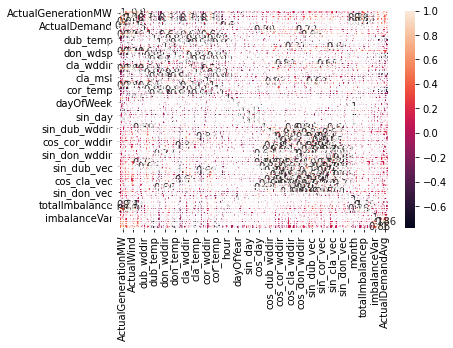

In [125]:
# Generating a correlation plot of all columns to explore dependencies
import seaborn as sns
import matplotlib.pyplot as plt
hm = sns.heatmap(df1.corr(), annot = True)
#hm.set(xlabel='\nIRIS Flower Details', ylabel='IRIS Flower Details\t', title = "Correlation matrix of IRIS data\n")
corr.style.background_gradient(cmap='coolwarm')
plt.show()

### Producing correlation graphs for specific combinations of weather cols

C:\Users\kevin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


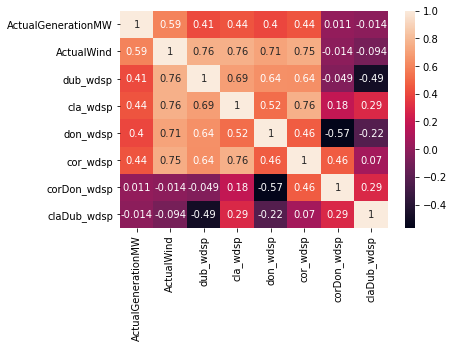

In [44]:
# Generating smaller correlation plots for specific columns, here it's the dependency of wind speeds
df=df._convert(numeric=True)
dfWind= df[["ActualGenerationMW","ActualWind",'dub_wdsp','cla_wdsp','don_wdsp','cor_wdsp']]
dfWind["corDon_wdsp"]= dfWind['cor_wdsp']-dfWind['don_wdsp']
dfWind["claDub_wdsp"]= dfWind['cla_wdsp']-dfWind['dub_wdsp']
hm = sns.heatmap(dfWind.corr(), annot = True)
#hm.set(xlabel='\nIRIS Flower Details', ylabel='IRIS Flower Details\t', title = "Correlation matrix of IRIS data\n")
corr.style.background_gradient(cmap='coolwarm')
plt.show()

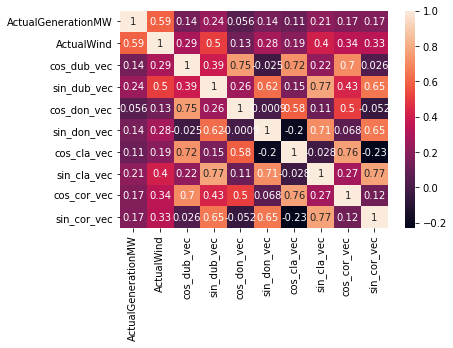

In [46]:
# Generating smaller correlation plots for specific columns, here it's the dependency of wind vectors
dfVec= df1[["ActualGenerationMW","ActualWind",'cos_dub_vec','sin_dub_vec','cos_don_vec','sin_don_vec','cos_cla_vec','sin_cla_vec','cos_cor_vec','sin_cor_vec']]

hm = sns.heatmap(dfVec.corr(), annot = True)

corr.style.background_gradient(cmap='coolwarm')
plt.show()

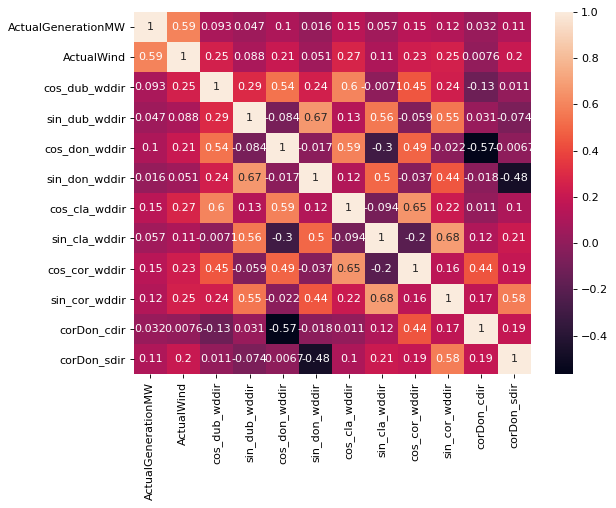

In [50]:
# Generating smaller correlation plots for specific columns, here it's the dependency of cos-sin wind directions
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

dfVec= df1[["ActualGenerationMW","ActualWind",'cos_dub_wddir','sin_dub_wddir','cos_don_wddir','sin_don_wddir','cos_cla_wddir','sin_cla_wddir','cos_cor_wddir','sin_cor_wddir']]
dfVec["corDon_cdir"]= dfVec['cos_cor_wddir']-dfVec['cos_don_wddir']
dfVec["corDon_sdir"]= dfVec['sin_cor_wddir']-dfVec['sin_don_wddir']

hm = sns.heatmap(dfVec.corr(), annot = True)
#hm.set(xlabel='\nIRIS Flower Details', ylabel='IRIS Flower Details\t', title = "Correlation matrix of IRIS data\n")
corr.style.background_gradient(cmap='coolwarm')
#plt.size(7,7)
plt.show()

### investigating variance invlation factor 

The variance inflation factor is essential for further looking at indepence of columns

In [86]:
X = df1[['sin_hour', 'sin_day', 'cos_hour','cos_day',
        "ActualWind",'dub_wdsp','cla_wdsp','don_wdsp','cor_wdsp',
        'ActualGenerationMW', 'ForecastWind', 'cos_dub_wddir', 'sin_dub_wddir',
        'cos_don_wddir', 'sin_don_wddir', 'cos_cla_wddir', 'sin_cla_wddir',
        'cos_cor_wddir', 'sin_cor_wddir']]

In [88]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.api import add_constant
X = add_constant(X)

vif = [variance_inflation_factor(X.to_numpy(), i) for i in range(X.to_numpy().shape[1])]

print(vif[1:])




[inf, inf, inf, inf, 13.052682846331967, 3.4992905008422146, 3.356745219655735, 2.4537500316103573, 3.2605424913646566, 2.08673625308065, 15.597236230493134, 2.025190238955787, 2.411133448999, 2.0144253285113654, 2.0008175577791865, 2.495927737235987, 2.915905729268956, 2.1647192418980805, 2.6422374104699204]


## 5. Energy Prices Dataset <a name="ePrice"></a>

### 5.1 Energy Price Analysis <a name="ePriceAnal"></a>

In [89]:
import pandas as pd
import numpy as np
import datetime as dt

In [126]:
#Importing the electricity price dataset
ePrice = pd.read_csv('data/ePrice.csv')
ePrice.columns= ['StartTime', 'EndTime', 'NetImbalanceVolume','ImbalanceSettlementPrice']
ePrice


,StartTime,EndTime,NetImbalanceVolume,ImbalanceSettlementPrice
0,2022-05-27T00:00:00,\t2022-05-27T00:30:00,-29.291,74.45
1,2022-05-27T00:30:00,\t2022-05-27T01:00:00,-23.329,82.32
2,2022-05-27T01:00:00,\t2022-05-27T01:30:00,-36.292,52.02
3,2022-05-27T01:30:00,\t2022-05-27T02:00:00,-42.894,-107.00
4,2022-05-27T02:00:00,\t2022-05-27T02:30:00,-33.407,43.87
...,...,...,...,...
1103,2022-07-01T21:30:00,\t2022-07-01T22:00:00,15.843,222.43
1104,2022-07-01T22:00:00,\t2022-07-01T22:30:00,32.151,150.85
1105,2022-07-01T22:30:00,\t2022-07-01T23:00:00,24.988,147.63
1106,2022-07-01T23:00:00,\t2022-07-01T23:30:00,30.974,146.90


In [91]:
ePrice = pd.read_csv('data/ePrice.csv')
ePrice=ePrice._convert(numeric=True)
ePrice.columns= ['StartTime', 'EndTime', 'NetImbalanceVolume','ImbalanceSettlementPrice']
ePrice = ePrice[ePrice['NetImbalanceVolume'].notna()]
ePrice = ePrice[ePrice['ImbalanceSettlementPrice'].notna()]


In [92]:
#Below commnand fails as the starttime is outside the bounds of the first dataset
'''ePrice['date2'] = [dt.datetime.strptime(d,"%Y-%m-%dT%H:%M:%S") for d in ePrice["StartTime"] ]
ePrice['minute'] = ePrice['date2'].dt.minute
ePrice = ePrice[ePrice['minute'] == 0]
weatherPrice = pd.merge(ePrice,weatherMerged, on = 'date2')
'''


'ePrice[\'date2\'] = [dt.datetime.strptime(d,"%Y-%m-%dT%H:%M:%S") for d in ePrice["StartTime"] ]\nePrice[\'minute\'] = ePrice[\'date2\'].dt.minute\nePrice = ePrice[ePrice[\'minute\'] == 0]\nweatherPrice = pd.merge(ePrice,weatherMerged, on = \'date2\')\n'

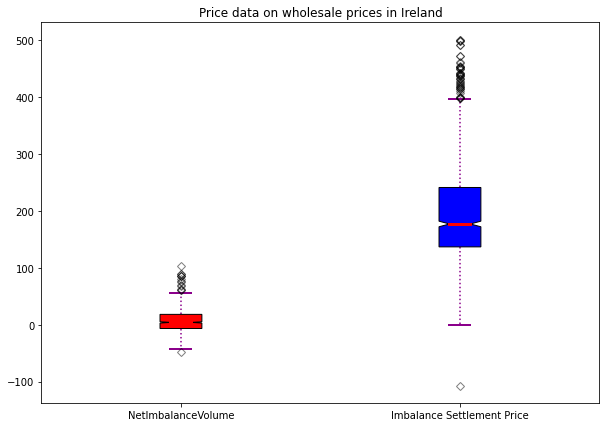

In [93]:
# Looking at variation of inputs for the electricity price outliers
import matplotlib.pyplot as plt
import numpy as np
 
# Creating dataset
np.random.seed(10)
data_1 = ePrice['NetImbalanceVolume']
data_2 = ePrice['ImbalanceSettlementPrice']
data = [data_1, data_2]
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 1)
 
colors = ['red','blue']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_xticklabels(['NetImbalanceVolume', 'Imbalance Settlement Price'])

 
# Adding title
plt.title("Price data on wholesale prices in Ireland")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()

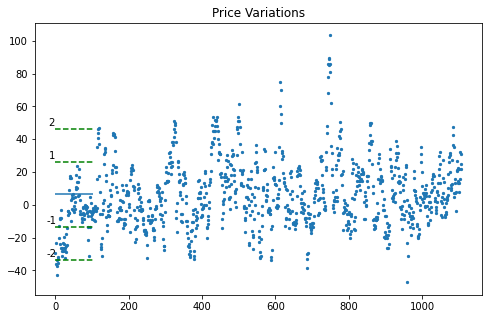

In [129]:
# Plotting the variation of settlement imbalance volume

import matplotlib.pyplot as plt
# Plotting the price variations of wholesale electricity 
plt.figure(figsize=(8,5))
plt.title("Price Variations") # Title
#plt.ylim(-40,40) # Setting y limits
plt.scatter(x=ePrice.index, y=ePrice['NetImbalanceVolume'], s=5); # Plotting scatter


plt.hlines(y=ePrice['NetImbalanceVolume'].mean(), xmin=0, xmax=max(ePrice['NetImbalanceVolume'])) # Mean


for std_int in [-2, -1, 1, 2]: # Going through different stds from the mean
    standard_deviation = ePrice['NetImbalanceVolume'].mean() + ePrice['NetImbalanceVolume'].std()*std_int
    
    plt.hlines(y=standard_deviation,
               xmin=0,
               xmax=max(ePrice['NetImbalanceVolume']),
               linestyles='dashed',
               colors='green'); # 1 std above
    
    # Giving labels to the lines we just drew
# Plotting the imbalance between settlement price
    plt.text(y=standard_deviation + 2, x=-10, s=std_int, ha='center')

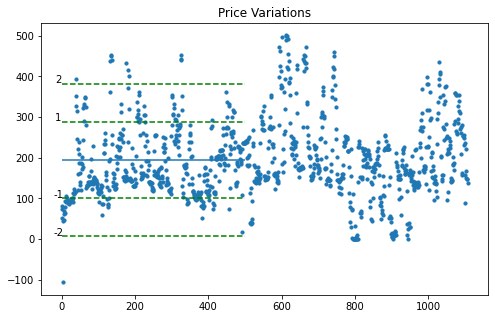

In [130]:
# Plotting the imbalance between settlement price

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.title("Price Variations") # Title
#plt.ylim(-40,40) # Setting y limits
plt.scatter(x=ePrice.index, y=ePrice['ImbalanceSettlementPrice'], s=10); # Plotting scatter


plt.hlines(y=ePrice['ImbalanceSettlementPrice'].mean(), xmin=0, xmax=max(ePrice['ImbalanceSettlementPrice'])) # Mean


for std_int in [-2, -1, 1, 2]: # Going through different stds from the mean
    standard_deviation = ePrice['ImbalanceSettlementPrice'].mean() + ePrice['ImbalanceSettlementPrice'].std()*std_int
    
    plt.hlines(y=standard_deviation,
               xmin=0,
               xmax=max(ePrice['ImbalanceSettlementPrice']),
               linestyles='dashed',
               colors='green'); # 1 std above
    
    # Giving labels to the lines we just drew
    plt.text(y=standard_deviation + 2, x=-10, s=std_int, ha='center')

### 5.2 Corelations between settlement price and wind generation <a name="ePriceCor"></a>

Columns are given by Index(['date2', 'EndTime', 'NetImbalanceVolume', 'ImbalanceSettlementPrice',
       'ActualGenerationMW', 'ForecastWind', 'ActualWind', 'ActualDemand',
       'dub_wddir', 'dub_wdsp', 'dub_temp', 'dub_msl', 'don_wddir', 'don_wdsp',
       'don_temp', 'don_msl', 'cla_wddir', 'cla_wdsp', 'cla_temp', 'cla_msl',
       'cor_wddir', 'cor_wdsp', 'cor_temp', 'cor_msl', 'hour', 'dayOfWeek',
       'dayOfYear', 'sin_hour', 'sin_day', 'cos_hour', 'cos_day',
       'sin_dub_wddir', 'cos_dub_wddir', 'sin_cor_wddir', 'cos_cor_wddir',
       'sin_cla_wddir', 'cos_cla_wddir', 'sin_don_wddir', 'cos_don_wddir',
       'cos_dub_vec', 'sin_dub_vec', 'cos_cor_vec', 'sin_cor_vec',
       'cos_cla_vec', 'sin_cla_vec', 'cos_don_vec', 'sin_don_vec', 'year',
       'month', 'totalImbalance', 'totalImbalancep', 'imbalanceAverage',
       'imbalanceVar', 'imbalanceVarAvg', 'ActualDemandAvg'],
      dtype='object')
Correlation Co-efficient is given by [[ 1.         -0.37374837]
 [-0.37374837 

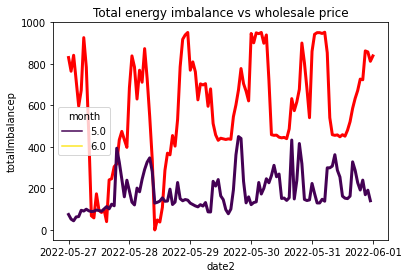

In [131]:
# Plotting change of volume and price over time

df1['dayOfWeek']= df1['date2'].dt.day_of_week
df1['year']= df1['date2'].dt.year
df1['month']= df1['date2'].dt.month


df1['totalImbalance']= df1['ActualGenerationMW']-df1['ActualDemand']
df1['totalImbalancep']=df1['totalImbalance']-min(df1['totalImbalance'])


df1['imbalanceAverage'] = df1.totalImbalance.rolling(window=24*14).mean()
df1['imbalanceVar']=df1.totalImbalance.rolling(24).var()
df1['imbalanceVarAvg'] = df1.imbalanceVar.rolling(window=24*14).mean()

ePrice.columns = ['date2','EndTime','NetImbalanceVolume','ImbalanceSettlementPrice']
ePrice['date2'] =  pd.to_datetime(ePrice['date2'])
ePriceDF=pd.merge(df1,ePrice, how='inner', left_index=True, right_index=True)
ePriceDF=pd.merge(ePrice, df1, how='outer', on='date2')
#Pretty small number of columns, need to get more data, hopefully next month get's pushed soon
ePriceDF=ePriceDF.dropna()
print("Columns are given by",ePriceDF.columns)
corcoef= np.corrcoef(ePriceDF['ImbalanceSettlementPrice'], ePriceDF['imbalanceVarAvg'])
print("Correlation Co-efficient is given by",corcoef)
ePriceDF['totalImbalancep']=ePriceDF['totalImbalance']-min(ePriceDF['totalImbalance'])




ax = sns.lineplot(data=ePriceDF, x ='date2', y = 'totalImbalancep', color = 'red',
                  legend='full', lw=3)

ax = sns.lineplot(data=ePriceDF, x ='date2', y = 'ImbalanceSettlementPrice',
                  hue='month', palette='viridis',
                  legend='full', lw=3)


np.corrcoef(ePriceDF['ImbalanceSettlementPrice'], ePriceDF['totalImbalancep'])
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
#plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total energy imbalance vs wholesale price')
#plt.gcf().autofmt_xdate()
plt.show()

C:\Users\kevin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



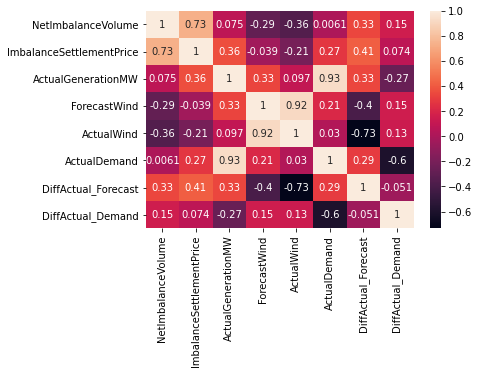

In [132]:
#Generating a correlation plot of the input variables
ePriceDFCorr = ePriceDF[['NetImbalanceVolume', 'ImbalanceSettlementPrice','ActualGenerationMW', 'ForecastWind', 'ActualWind', 'ActualDemand']]
ePriceDFCorr["DiffActual_Forecast"]= ePriceDFCorr['ForecastWind']-ePriceDFCorr['ActualWind']
ePriceDFCorr["DiffActual_Demand"]= ePriceDFCorr['ActualWind']-ePriceDFCorr['ActualDemand']
ePriceDFCorr["DiffActual_Demand"]= ePriceDFCorr['ActualGenerationMW']-ePriceDFCorr['ActualDemand']


hm = sns.heatmap(ePriceDFCorr.corr(), annot = True)
#hm.set(xlabel='\nIRIS Flower Details', ylabel='IRIS Flower Details\t', title = "Correlation matrix of IRIS data\n")
corr.style.background_gradient(cmap='coolwarm')
plt.savefig('analysisImages/price_corr.png')

plt.show()


#• The Imbalance Settlement Price is the primary price used for settlement in the Balancing Market, and therefore it is an important signal for the whole market;



Text(0.5, 1.0, 'Actual Wind generation (MW)')

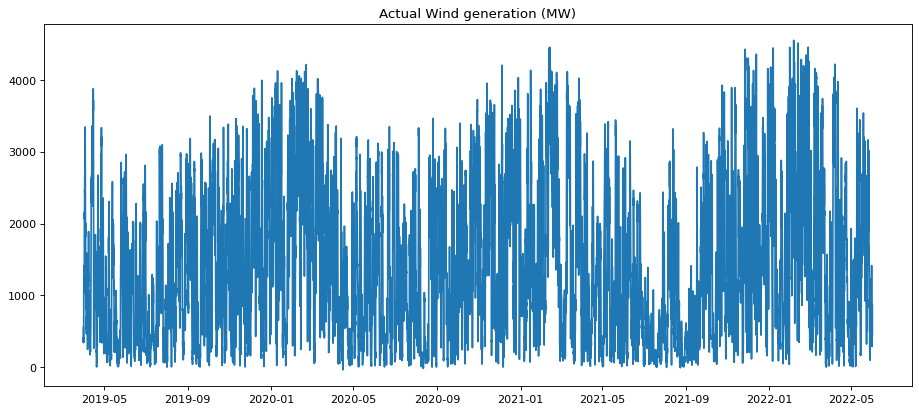

In [99]:
#Plotting 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as md
from matplotlib.pyplot import figure

figure(figsize=(14, 6), dpi=80)
tail=df1.tail(24*7)
y=df1['ActualWind']
x=df1['date2']


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(x,y)
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Actual Wind generation (MW)')
#plt.gcf().autofmt_xdate()

## Saving Cleaned dataset <a name="save"></a>

In [100]:
df1['totalImbalance'] = df1['ActualGenerationMW']-df1['ActualDemand']

In [101]:
print(df1.to_csv('data/chargeML.csv', index=False))


None


## Investigating energy usage change  following the Russia's invasion of Ukraine <a name="ukraine"></a>

Creating new column, date of year

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

C:\Users\kevin\AppData\Local\Temp/ipykernel_16664/1770928890.py:20: UserWarning:

FixedFormatter should only be used together with FixedLocator



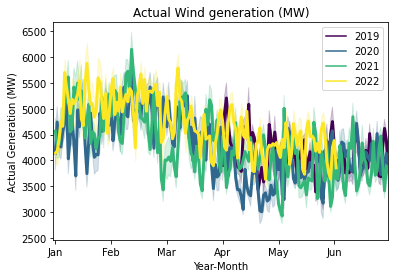

In [103]:
#Creating a plot of actual generation over the period to show changes from the Ukraine War
from datetime import datetime

ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'ActualGenerationMW',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Actual Generation (MW)')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Actual Wind generation (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

C:\Users\kevin\AppData\Local\Temp/ipykernel_16664/2490490111.py:20: UserWarning:

FixedFormatter should only be used together with FixedLocator



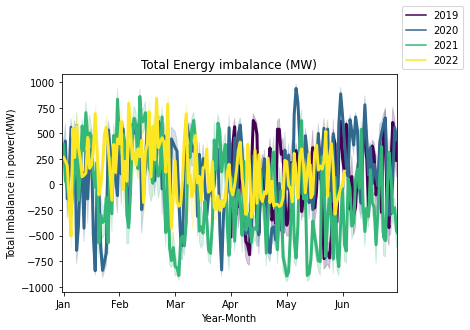

In [133]:
from datetime import datetime
#Creating a plot of total supply imbalance (Difference between supply and demand) over the period to show changes from the Ukraine War
ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'totalImbalance',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Total Imbalance in power(MW)')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total Energy imbalance (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

C:\Users\kevin\AppData\Local\Temp/ipykernel_16664/2954602016.py:22: UserWarning:

FixedFormatter should only be used together with FixedLocator



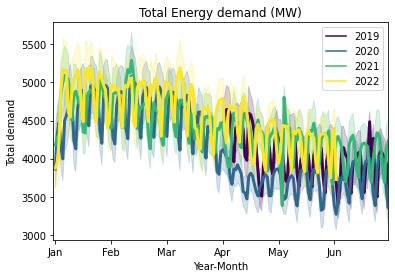

In [134]:
#Creating a plot of total demand over the period to show changes from the Ukraine War

from datetime import datetime

ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'ActualDemand',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Total demand')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total Energy demand (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

### Plotting moving average energy imabalance

#### Key dates

- 12th March 2020 - Lockdown announced
- 18th May 2020   - Restrictions eased
- 19th Oct 2020   - Lockdown
- 1st  Dec 2020   - Eased 
- 22nd Dec 2020   - Lockdown
- 28th Feb 2021   - Easing (Eased fully in July)
- 3rd  Dec 2021   - Lockdown
- 21st Jan 2022   - Eased



In [106]:
df1['imbalanceAverage'] = df1.totalImbalance.rolling(window=24*14).mean()

C:\Users\kevin\AppData\Local\Temp/ipykernel_16664/765314043.py:22: UserWarning:

FixedFormatter should only be used together with FixedLocator



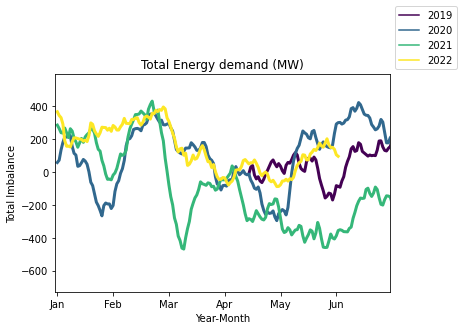

In [135]:
#Creating a plot of rolling imbalance average over the period to show changes from the Ukraine War

from datetime import datetime

ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'imbalanceAverage',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Total Imbalance')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total Energy demand (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

#### Calculating the rolling variance of the variables

In [108]:
df1['imbalanceAverage'] = df1.totalImbalance.rolling(window=24*14).mean()
df1['imbalanceVar']=df1.totalImbalance.rolling(24).var()
df1['imbalanceVarAvg'] = df1.imbalanceVar.rolling(window=24*14).mean()

C:\Users\kevin\AppData\Local\Temp/ipykernel_16664/2450885524.py:22: UserWarning:

FixedFormatter should only be used together with FixedLocator



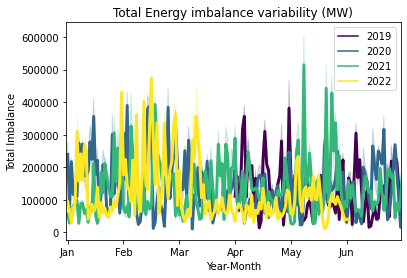

In [137]:
#Creating a plot of imbalance variability  over the period to show changes from the Ukraine War

from datetime import datetime

ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'imbalanceVar',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Total Imbalance')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total Energy imbalance variability (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

C:\Users\kevin\AppData\Local\Temp/ipykernel_16664/877126558.py:29: UserWarning:

FixedFormatter should only be used together with FixedLocator



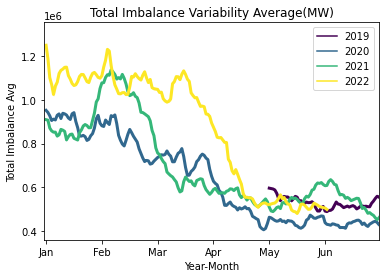

In [138]:
#Creating a plot of imbalance variability average over the period to show changes from the Ukraine War

df1['totalImbalance']    =df1['ActualWind']-df1['ActualDemand']
df1['imbalanceAverage']  =df1.totalImbalance.rolling(window=24*14).mean()
df1['imbalanceVar']      =df1.totalImbalance.rolling(24).var()
df1['imbalanceVarAvg']   =df1.imbalanceVar.rolling(window=24*14).mean()
df1['imbalanceVarAvg']   =df1.imbalanceVar.rolling(window=24*30).mean()

ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'imbalanceVarAvg',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))

plt.legend(bbox_to_anchor=(1, 1))

plt.ylabel('Total Imbalance Avg')

plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total Imbalance Variability Average(MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.savefig('analysisImages/totalImbalanceVariation.png')
plt.show()

In [112]:
df1['ActualDemandAvg'] = df1.ActualDemand.rolling(window=24*14).mean()

C:\Users\kevin\AppData\Local\Temp/ipykernel_16664/2646011181.py:22: UserWarning:

FixedFormatter should only be used together with FixedLocator



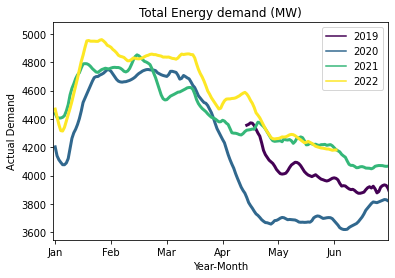

In [139]:
#Creating a plot of average total demand over the period to show changes from the Ukraine War

from datetime import datetime

ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'ActualDemandAvg',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Actual Demand')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Total Energy demand (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

C:\Users\kevin\AppData\Local\Temp/ipykernel_16664/1830111005.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator



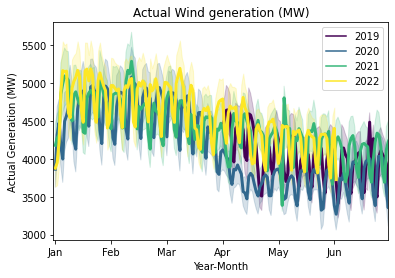

In [140]:
#Creating a plot of Actual Generation over the period to show changes from the Ukraine War

from datetime import datetime
ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'ActualDemand',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Actual Generation (MW)')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Actual Wind generation (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

C:\Users\kevin\AppData\Local\Temp/ipykernel_16664/1201087303.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator



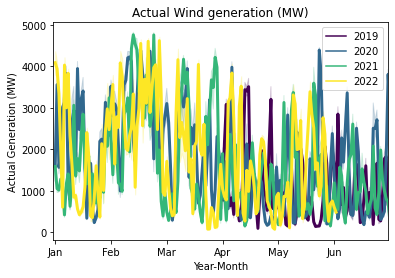

In [141]:
from datetime import datetime

#Creating a plot of average actual demand generation over the period to show changes from the Ukraine War


ax = sns.lineplot(data=df1, x ='dayOfYear', y = 'ForecastWind',
                  hue='year', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Actual Generation (MW)')
plt.xlabel('Year-Month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0, 6, 12, 18]))
#plt.gca().xaxis.set_major_locator(md.HourLocator(byhour = [0 ]))
plt.title('Actual Wind generation (MW)')
#plt.gcf().autofmt_xdate()
months = list(df1.month)
ax.set_xticklabels(np.unique(months))

plt.xticks(np.arange(1, 360, 30))

#ax.set_xticks(list(range(0,12)))
ax.set_xticklabels([datetime(2017,_,1).strftime('%b') for _ in range(1,13)])
plt.xlim([0, 180])
plt.show()

In [117]:
import plotly.graph_objects as go

#extract color palette, the palette can be changed
pal = list(sns.color_palette(palette='viridis', n_colors=len(months)).as_hex())

fig = go.Figure()